In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt


In [2]:
import os
import numpy as np
import random
import torch
from distutils.version import LooseVersion as Version

In [3]:
def setAllSeeds(seed):
  os.environ['MY_GLOBAL_SEED'] = str(seed)
  random.seed(seed)
  np.random.seed(seed)
  torch.manual_seed(seed)
  torch.cuda.manual_seed_all(seed)

def setDeterministic():
  if (torch.cuda.is_available()):
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

  if (torch.__version__ <= Version("1.7")):
    torch.set_deterministic(True)
  else:
    torch.use_deterministic_algorithms(True)

def computeAccu(model,dataLoader,device):
  model.eval()
  with torch.no_grad():
    correctPred = 0
    totalPred = 0

    for features,targets in dataLoader:
      features = features.to(device)
      targets  = targets.to(device)

      logits   = model(features)
      _ , predLabel = torch.max(logits,1)
      totalPred += targets.size(0)
      correctPred += (predLabel == targets).sum()

  return correctPred.float()/totalPred * 100

In [4]:
import time
import torch

def modelTrainer(model1, numEpochs, trainLoader,testLoader,valLoader, opt, device):
  startTime = time.time()
  miniBatchLoss = []
  trainAccLoss = []
  valAccLoss = []
  for e in range(numEpochs):
    model1.train()
    for batchIdx, (features,targets) in enumerate(trainLoader):
      features = features.to(device)
      targets  = targets.to(device)

      logits = model1(features)
      # _, predLabel = torch.max(logits,1)

      cost = torch.nn.functional.cross_entropy(logits,targets)
      opt.zero_grad()
      cost.backward()
      opt.step()
      miniBatchLoss.append(cost.item())
      if ( not (batchIdx%50) ):
        print('Epoch:%03d/%03d | Batch:%03d/%03d |  Cost:%.4f' %(e+1, numEpochs, batchIdx, len(trainLoader), cost.item()))
    with torch.no_grad():
      print('Epoch:%03d/%03d |' %(e+1, numEpochs))
      trainLoss = computeAccu(model1, trainLoader,device)
      valLoss   = computeAccu(model1, valLoader  ,device)
      trainAccLoss.append(trainLoss)
      valAccLoss.append(valLoss)
      print(f'Train Acc {trainLoss :.4f}%')
      print(f'Val Acc   {valLoss:.4f}%')
      print(f'Time Taken: {((time.time()-startTime)/60):.2f} min')
#     break
  testLoss = computeAccu(model1, testLoader, device)
  print(f'Test Acc   {testLoss:.4f}%')
  print(f'Total Time Taken: {((time.time()-startTime)/60):.2f} min')

  return miniBatchLoss, trainAccLoss, valAccLoss


In [5]:
import os
import matplotlib.pyplot as plt
import numpy as np
import torch

def plotTrainingLoss(miniBatchLoss,numEpoch,iterPerEpoch,resultsDir=None,avgIter = 100):
  plt.figure()
  ax1 = plt.subplot(1,1,1)
  ax1.plot(range(len(miniBatchLoss)), miniBatchLoss, label='Mini Batch Loss')
  if len(miniBatchLoss) > 1000:
    ax1.set_ylim([0,np.max(miniBatchLoss[1000:])*1.5])
  ax1.set_xlabel('Iterations')
  ax1.set_ylabel('Loss')
  ax1.plot(np.convolve(miniBatchLoss,np.ones(avgIter,)/avgIter,mode='valid'),label='Running Avg')
  ax1.legend()

  ax2 = ax1.twiny()
  newLabel = list(range(numEpoch+1))
  newPos = [e*iterPerEpoch for e in newLabel]
  # ax2.set_xticks(newpos[::10])
  # ax2.set_xticklabels(newlabel[::10])

  ax2.set_xticks(newPos[::10])
  ax2.set_xticklabels(newLabel[::10])
  ax2.spines['bottom'].set_position(('outward',45))
  ax2.set_xlabel("Epochs")
  ax2.set_xlim(ax1.get_xlim())

  plt.tight_layout()

  if(resultsDir is not None):
    imagePath = os.path.join(resultsDir, 'plotTrainingLoss.pdf')
    plt.savefig(imagePath)

def plotAccuracy(trainAccList, valAccList, resultsDir = None):
  numEpoch = len(trainAccList)
  plt.plot(np.arange(1,numEpoch+1),trainAccList,label='Training')
  plt.plot(np.arange(1,numEpoch+1),valAccList,label='Validation')
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.legend()

  plt.tight_layout()


  if(resultsDir is not None):
    imagePath = os.path.join(resultsDir, 'plotAccTrainingValidation.pdf')
    plt.savefig(imagePath)

def show_examples(model, dataLoader):
  for batchIdx, (features, targets) in enumerate(dataLoader):
    with torch.no_grad():
      features = features.to(torch.device('cpu'))
      targets  = targets.to(torch.device('cpu'))
      logits = model(features)
      predictions = torch.argmax(logits,dim=1)
    break

  fig, axes = plt.subplots(nrows=3,ncols=5,sharex=True,sharey=True)
  nhwcImage = np.transpose(features,axes = (0,2,3,1))
  nhwImage  = np.squeeze(nhwcImage.numpy(), axis=3)

  for idx,ax in enumerate(axes.ravel()):
    ax.imshow(nhwImage[idx],cmap='binary')
    ax.title.set_text(f'P: {predictions[idx]} | T: {targets[idx]}')
    ax.axison = False

  plt.tight_layout()
  plt.show()

In [6]:
import torch
from torch.utils.data import sampler
from torchvision import datasets
from torch.utils.data import DataLoader
from torch.utils.data import SubsetRandomSampler
from torchvision import transforms

def getDataLoadersMNIST(batchSize, numWorkers=0,validFraction =None, trainTransforms =None, testTransforms =None ):
  if(trainTransforms is None):
    trainTransforms = transforms.ToTensor()
  if(testTransforms is None):
    testTransforms = transforms.ToTensor()

  trainDataset = datasets.MNIST(root='data',
                              train=True,
                              transform=trainTransforms,
                              download = True)

  testDataset = datasets.MNIST(root='data',
                              train=True,
                              transform=testTransforms)

  testDataset = datasets.MNIST(root='data',
                              train=False,
                              transform=testTransforms)

  if(validFraction is not None):
    num = int(validFraction*60000)
    trainIndices = torch.arange(0,60000-num)
    valIndices = torch.arange(60000-num, 60000)

    trainSampler=SubsetRandomSampler(trainIndices)
    valSampler = SubsetRandomSampler(valIndices)

    trainLoader = DataLoader(dataset=trainDataset,
                         batch_size=batchSize,
                         num_workers=numWorkers,
                         drop_last = True,
                         sampler = trainSampler)
    valLoader = DataLoader(dataset=trainDataset,
                         batch_size=batchSize,
                         num_workers=numWorkers,
                         sampler = valSampler)
  else:
    trainLoader = DataLoader(dataset=trainDataset,
                         batch_size=batchSize,
                         num_workers=numWorkers,
                         drop_last = True,
                         shuffle=True)

  testLoader = DataLoader(dataset=testDataset,
                         batch_size=batchSize,
                         shuffle=False,
                         num_workers=numWorkers)

  if(validFraction is None):
    return trainLoader,testLoader
  else:
    return trainLoader,valLoader,testLoader

In [7]:
RANDOM_SEED = 123
BATCH_SIZE = 256
NUM_HIDDEN_1 = 75
NUM_HIDDEN_2 = 45
NUM_EPOCHS = 50
DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [8]:
setAllSeeds(RANDOM_SEED)
setDeterministic()

/tmp/ipykernel_18/3097456502.py:13: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if (torch.__version__ <= Version("1.7")):


In [9]:
trainLoader, validLoader, testLoader = getDataLoadersMNIST(
    batchSize=BATCH_SIZE,
    validFraction=0.1)

# Checking the dataset
for images, labels in trainLoader:
    print('Image batch dimensions:', images.shape)
    print('Image label dimensions:', labels.shape)
    print('Class labels of 10 examples:', labels[:10])
    break

100%|██████████| 9912422/9912422 [00:00<00:00, 88016443.38it/s]


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 51657012.29it/s]


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 17121255.34it/s]


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 15981987.22it/s]


Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw

Image batch dimensions: torch.Size([256, 1, 28, 28])
Image label dimensions: torch.Size([256])
Class labels of 10 examples: tensor([4, 5, 8, 9, 9, 4, 9, 9, 3, 9])


In [10]:
class MultilayerPerceptron(torch.nn.Module):

    def __init__(self, numFeatures, numClasses, dropProba, numHidden1, numHidden2):
        super().__init__()

        self.my_network = torch.nn.Sequential(
            # 1st hidden layer
            torch.nn.Flatten(),
            torch.nn.Linear(numFeatures, numHidden1),
            torch.nn.ReLU(),
            torch.nn.Dropout(dropProba),
            # 2nd hidden layer
            torch.nn.Linear(numHidden1, numHidden2),
            torch.nn.ReLU(),
            torch.nn.Dropout(dropProba),
            # output layer
            torch.nn.Linear(numHidden2, numClasses)
        )

    def forward(self, x):
        logits = self.my_network(x)
        return logits

# With Drop Probability 0

In [11]:
torch.manual_seed(RANDOM_SEED)
model = MultilayerPerceptron(numFeatures=28*28,
                             numHidden1=NUM_HIDDEN_1,
                             numHidden2=NUM_HIDDEN_2,
                             dropProba=0.0,
                             numClasses=10)
model = model.to(DEVICE)

optimizer = torch.optim.SGD(model.parameters(), lr=0.1)


In [12]:
miniBatchLossList, trainAccList, validAccList = modelTrainer(
    model1=model,
    numEpochs=NUM_EPOCHS,
    trainLoader=trainLoader,
    valLoader=validLoader,
    testLoader=testLoader,
    opt=optimizer,
    device=DEVICE)

Epoch:001/050 | Batch:000/210 |  Cost:2.3093
Epoch:001/050 | Batch:050/210 |  Cost:1.8443
Epoch:001/050 | Batch:100/210 |  Cost:0.7622
Epoch:001/050 | Batch:150/210 |  Cost:0.6539
Epoch:001/050 | Batch:200/210 |  Cost:0.5036
Epoch:001/050 |
Train Acc 86.5625%
Val Acc   89.1167%
Time Taken: 0.22 min
Epoch:002/050 | Batch:000/210 |  Cost:0.4685
Epoch:002/050 | Batch:050/210 |  Cost:0.4341
Epoch:002/050 | Batch:100/210 |  Cost:0.3330
Epoch:002/050 | Batch:150/210 |  Cost:0.3330
Epoch:002/050 | Batch:200/210 |  Cost:0.3604
Epoch:002/050 |
Train Acc 90.2288%
Val Acc   92.1500%
Time Taken: 0.45 min
Epoch:003/050 | Batch:000/210 |  Cost:0.2568
Epoch:003/050 | Batch:050/210 |  Cost:0.2746
Epoch:003/050 | Batch:100/210 |  Cost:0.2673
Epoch:003/050 | Batch:150/210 |  Cost:0.2206
Epoch:003/050 | Batch:200/210 |  Cost:0.3525
Epoch:003/050 |
Train Acc 91.0826%
Val Acc   92.5667%
Time Taken: 0.68 min
Epoch:004/050 | Batch:000/210 |  Cost:0.3443
Epoch:004/050 | Batch:050/210 |  Cost:0.2957
Epoch:004/

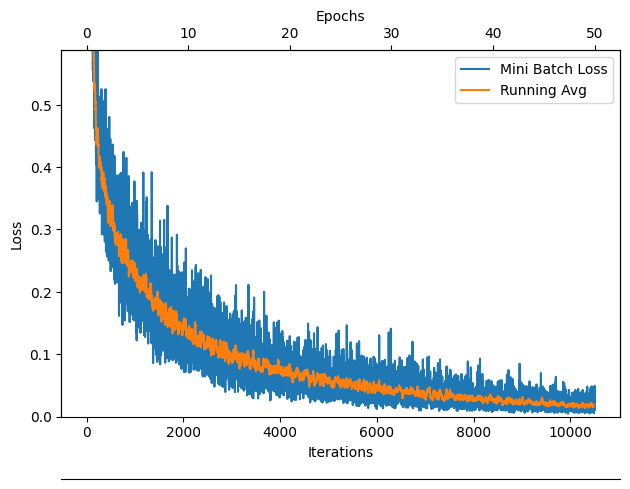

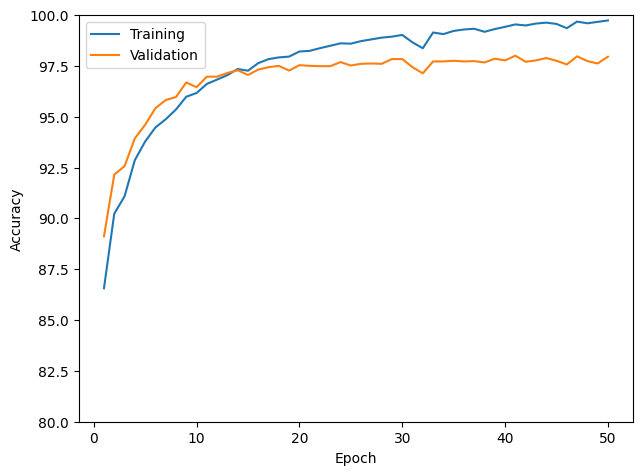

In [13]:
plotTrainingLoss(miniBatchLoss=miniBatchLossList,
                   numEpoch=NUM_EPOCHS,
                   iterPerEpoch=len(trainLoader),
                   resultsDir=None,
                   avgIter=20)    #plotTrainingLoss(miniBatchLoss,numEpoch,iterPerEpoch,resultsDir=None,avgIter = 100)
plt.show()
plotAccuracy(trainAccList,validAccList)
plt.ylim([80,100])
plt.show()

# With Drop Probability 0.5

In [14]:
torch.manual_seed(RANDOM_SEED)
model = MultilayerPerceptron(numFeatures=28*28,
                             numHidden1=NUM_HIDDEN_1,
                             numHidden2=NUM_HIDDEN_2,
                             dropProba=0.5,
                             numClasses=10)
model = model.to(DEVICE)

optimizer = torch.optim.SGD(model.parameters(), lr=0.1)


In [15]:
miniBatchLossList, trainAccList, validAccList = modelTrainer(
    model1=model,
    numEpochs=NUM_EPOCHS,
    trainLoader=trainLoader,
    valLoader=validLoader,
    testLoader=testLoader,
    opt=optimizer,
    device=DEVICE)

Epoch:001/050 | Batch:000/210 |  Cost:2.3132
Epoch:001/050 | Batch:050/210 |  Cost:2.0828
Epoch:001/050 | Batch:100/210 |  Cost:1.5250
Epoch:001/050 | Batch:150/210 |  Cost:1.2467
Epoch:001/050 | Batch:200/210 |  Cost:1.0186
Epoch:001/050 |
Train Acc 82.3624%
Val Acc   85.4667%
Time Taken: 0.22 min
Epoch:002/050 | Batch:000/210 |  Cost:0.9355
Epoch:002/050 | Batch:050/210 |  Cost:0.9608
Epoch:002/050 | Batch:100/210 |  Cost:0.7889
Epoch:002/050 | Batch:150/210 |  Cost:0.7475
Epoch:002/050 | Batch:200/210 |  Cost:0.6573
Epoch:002/050 |
Train Acc 88.2459%
Val Acc   90.5000%
Time Taken: 0.44 min
Epoch:003/050 | Batch:000/210 |  Cost:0.7553
Epoch:003/050 | Batch:050/210 |  Cost:0.6540
Epoch:003/050 | Batch:100/210 |  Cost:0.5696
Epoch:003/050 | Batch:150/210 |  Cost:0.7052
Epoch:003/050 | Batch:200/210 |  Cost:0.5454
Epoch:003/050 |
Train Acc 90.1953%
Val Acc   92.0833%
Time Taken: 0.66 min
Epoch:004/050 | Batch:000/210 |  Cost:0.6222
Epoch:004/050 | Batch:050/210 |  Cost:0.5641
Epoch:004/

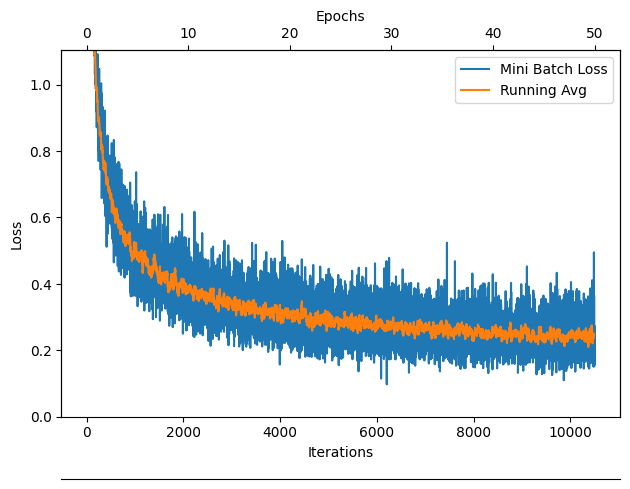

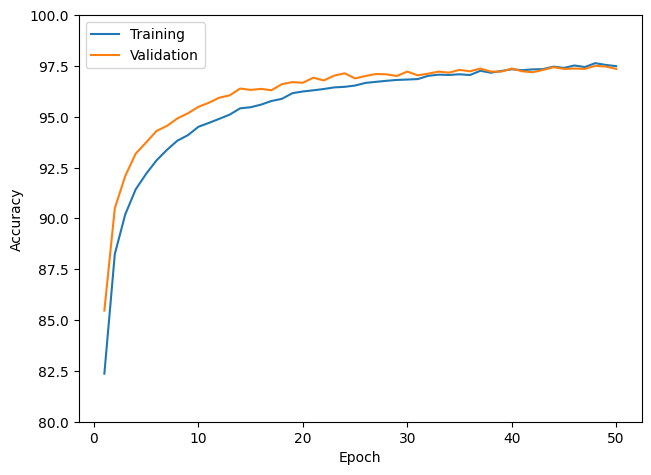

In [16]:
plotTrainingLoss(miniBatchLoss=miniBatchLossList,
                   numEpoch=NUM_EPOCHS,
                   iterPerEpoch=len(trainLoader),
                   resultsDir=None,
                   avgIter=20)    #plotTrainingLoss(miniBatchLoss,numEpoch,iterPerEpoch,resultsDir=None,avgIter = 100)
plt.show()
plotAccuracy(trainAccList,validAccList)
plt.ylim([80,100])
plt.show()